<a href="https://colab.research.google.com/github/AndriyF-Git/Deep_Learning_IPZ43/blob/main/DeepLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Підключення до kaggle

In [ ]:
# !pip -q install -U kaggle
# !kaggle --version

# import os
# os.environ["KAGGLE_API_TOKEN"] = ""

# # тест
# !kaggle competitions list | head


Підключення до диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Завантаження датасету з kaggle

In [ ]:
%%bash
COMP="image-classification-real-or-ai-generated-photo"
mkdir -p /content/$COMP
kaggle competitions download -c $COMP -p /content/$COMP
unzip -q /content/$COMP/*.zip -d /content/$COMP
ls -lah /content/$COMP


total 8.0K
drwxr-xr-x 2 root root 4.0K Dec 23 16:30 .
drwxr-xr-x 1 root root 4.0K Dec 23 16:30 ..


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open /content/image-classification-real-or-ai-generated-photo/*.zip, /content/image-classification-real-or-ai-generated-photo/*.zip.zip or /content/image-classification-real-or-ai-generated-photo/*.zip.ZIP.

No zipfiles found.


Імпорти та конфіг

In [ ]:
import os, random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4
WD = 1e-2
MODEL_NAME = "tf_efficientnetv2_s"
NUM_WORKERS = 0
FOLDS_TO_TRAIN = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)


device: cpu


In [ ]:
DATA_DIR = "/content/image-classification-real-or-ai-generated-photo"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
sub_df   = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# submission columns
id_col = sub_df.columns[0]
target_col = sub_df.columns[1]

candidate_labels = [c for c in train_df.columns if c not in test_df.columns]
if target_col in train_df.columns:
    label_col = target_col
elif len(candidate_labels) == 1:
    label_col = candidate_labels[0]
else:
    for c in ["label", "target", "class", "is_ai", "generated"]:
        if c in train_df.columns:
            label_col = c
            break
    else:
        raise ValueError(f"Can't infer label column. train cols: {train_df.columns.tolist()}")

# image col: спільна колонка, що не id і не label
img_col = None
for c in train_df.columns:
    if c != label_col and c in test_df.columns and c != id_col:
        img_col = c
        break
if img_col is None:
    img_col = [c for c in train_df.columns if c != label_col][0]

print("id_col:", id_col)
print("img_col:", img_col)
print("label_col:", label_col)
print("submit target_col:", target_col)

import glob
import os

EXTS = [".jpg", ".jpeg", ".png", ".webp"]

def resolve_img_path(p, is_train: bool):
    base = TRAIN_DIR if is_train else TEST_DIR
    p = str(p)

    # якщо це вже існуючий шлях
    if os.path.exists(p):
        return p

    cand = os.path.join(DATA_DIR, p)
    if os.path.exists(cand):
        return cand

    cand = os.path.join(base, p)
    if os.path.exists(cand):
        return cand

    root, ext = os.path.splitext(p)
    if ext == "":
        for e in EXTS:
            cand = os.path.join(base, p + e)
            if os.path.exists(cand):
                return cand

        # 5) якщо файли у підпапках — шукаємо рекурсивно
        for e in EXTS:
            hits = glob.glob(os.path.join(base, "**", p + e), recursive=True)
            if hits:
                return hits[0]

    # останній шанс: шукаємо за basename як є (коли p = "306.jpg", але лежить в підпапці)
    hits = glob.glob(os.path.join(base, "**", os.path.basename(p)), recursive=True)
    if hits:
        return hits[0]

    return os.path.join(base, p)  # повертаємо “очікуваний” шлях для нормальної помилки


# sanity check
print("train sample path:", resolve_img_path(train_df.loc[0, img_col], True))
print("test sample path:", resolve_img_path(test_df.loc[0, img_col], False))

train_df[label_col].value_counts(normalize=True)



FileNotFoundError: [Errno 2] No such file or directory: '/content/image-classification-real-or-ai-generated-photo/train.csv'

In [ ]:
train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),

    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.75, 1.0), ratio=(0.9, 1.1)),

    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.1),
    # A.ImageCompression(quality_lower=60, quality_upper=100, p=0.35),
    A.Normalize(),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),

    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),

    A.Normalize(),
    ToTensorV2(),
])


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, is_train=True, tfms=None):
        self.df = df.reset_index(drop=True)
        self.is_train = is_train
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = resolve_img_path(row[img_col], self.is_train)

        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Can't read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.tfms is not None:
            img = self.tfms(image=img)["image"]

        if self.is_train:
            y = float(row[label_col])
            y = torch.tensor([y], dtype=torch.float32)
            return img, y
        else:
            return img, row[id_col]


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
train_df["fold"] = -1
for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df[label_col].astype(int))):
    train_df.loc[val_idx, "fold"] = fold

train_df["fold"].value_counts().sort_index()


,count
fold,
0,189
1,189
2,189
3,189
4,189


In [ ]:
def build_model():
    return timm.create_model(MODEL_NAME, pretrained=True, num_classes=1)

def train_fold(fold=0, save_best_by="loss"):
    """
    save_best_by: "loss" (min valid_loss) або "auc" (max valid_auc)
    """
    assert save_best_by in ["loss", "auc"]

    tr = train_df[train_df.fold != fold].copy()
    va = train_df[train_df.fold == fold].copy()

    dl_tr = DataLoader(
        ImgDataset(tr, True, train_tfms),
        batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=False
    )
    dl_va = DataLoader(
        ImgDataset(va, True, valid_tfms),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=False
    )

    model = build_model().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    loss_fn = nn.BCEWithLogitsLoss()

    use_amp = (device.type == "cuda")
    scaler = GradScaler(enabled=use_amp)

    # best tracking
    best_loss = 1e18
    best_auc = -1e18
    best_path = f"/content/best_fold{fold}_{save_best_by}.pt"

    history = {
        "fold": [],
        "epoch": [],
        "train_loss": [],
        "valid_loss": [],
        "valid_acc": [],
        "valid_auc": [],
        "lr": [],
    }

    for ep in range(EPOCHS):
        # train
        model.train()
        tr_losses = []

        for x, y in tqdm(dl_tr, desc=f"fold{fold} ep{ep+1}/{EPOCHS} train"):
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            with autocast(enabled=use_amp):
                logits = model(x)
                loss = loss_fn(logits, y)

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            tr_losses.append(loss.item())

        # valid
        model.eval()
        va_losses = []
        probs_all = []
        targets_all = []

        with torch.no_grad():
            for x, y in tqdm(dl_va, desc=f"fold{fold} ep{ep+1}/{EPOCHS} valid"):
                x, y = x.to(device), y.to(device)

                with autocast(enabled=use_amp):
                    logits = model(x)
                    loss = loss_fn(logits, y)

                va_losses.append(loss.item())

                probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
                targets = y.detach().cpu().numpy().reshape(-1)

                probs_all.append(probs)
                targets_all.append(targets)

        tr_loss = float(np.mean(tr_losses))
        va_loss = float(np.mean(va_losses))

        probs_all = np.concatenate(probs_all)
        targets_all = np.concatenate(targets_all).astype(int)

        preds = (probs_all >= 0.5).astype(int)
        va_acc = float((preds == targets_all).mean())

        try:
            va_auc = float(roc_auc_score(targets_all, probs_all))
        except ValueError:
            va_auc = float("nan")

        current_lr = opt.param_groups[0]["lr"]

        history["fold"].append(fold)
        history["epoch"].append(ep + 1)
        history["train_loss"].append(tr_loss)
        history["valid_loss"].append(va_loss)
        history["valid_acc"].append(va_acc)
        history["valid_auc"].append(va_auc)
        history["lr"].append(current_lr)

        print(
            f"fold{fold} ep{ep+1}: "
            f"train_loss={tr_loss:.4f} valid_loss={va_loss:.4f} "
            f"valid_acc={va_acc:.4f} valid_auc={va_auc:.4f} lr={current_lr:.2e}"
        )

        # save best
        if save_best_by == "loss":
            if va_loss < best_loss:
                best_loss = va_loss
                torch.save(model.state_dict(), best_path)
        else:  # "auc"
            if (not np.isnan(va_auc)) and (va_auc > best_auc):
                best_auc = va_auc
                torch.save(model.state_dict(), best_path)

        sched.step()

    return best_path, pd.DataFrame(history)




In [ ]:
model_paths = []
metrics_dfs = []

for fold in range(FOLDS_TO_TRAIN):
    best_path, df_hist = train_fold(fold, save_best_by="loss")
    model_paths.append(best_path)
    metrics_dfs.append(df_hist)

metrics = pd.concat(metrics_dfs, ignore_index=True)
metrics.to_csv("/content/metrics_history.csv", index=False)
print("Saved metrics:", "/content/metrics_history.csv")
model_paths


/tmp/ipython-input-2968484647.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


fold0 ep1/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep1/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep1: train_loss=2.7907 valid_loss=2.3299 valid_acc=0.7831 valid_auc=0.8586 lr=1.00e-04


fold0 ep2/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep2/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep2: train_loss=1.2199 valid_loss=1.5126 valid_acc=0.8201 valid_auc=0.9276 lr=9.05e-05


fold0 ep3/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep3/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep3: train_loss=0.7697 valid_loss=1.2425 valid_acc=0.8413 valid_auc=0.9401 lr=6.55e-05


fold0 ep4/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep4/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep4: train_loss=0.3656 valid_loss=0.9340 valid_acc=0.8995 valid_auc=0.9482 lr=3.45e-05


fold0 ep5/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep5/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold0 ep5: train_loss=0.4038 valid_loss=0.9292 valid_acc=0.8783 valid_auc=0.9469 lr=9.55e-06


/tmp/ipython-input-2968484647.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


fold1 ep1/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep1/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep1: train_loss=3.2841 valid_loss=1.2869 valid_acc=0.8148 valid_auc=0.9229 lr=1.00e-04


fold1 ep2/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep2/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep2: train_loss=0.9262 valid_loss=1.0211 valid_acc=0.8783 valid_auc=0.9539 lr=9.05e-05


fold1 ep3/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep3/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep3: train_loss=0.5748 valid_loss=0.6797 valid_acc=0.9312 valid_auc=0.9697 lr=6.55e-05


fold1 ep4/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep4/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep4: train_loss=0.4368 valid_loss=1.0174 valid_acc=0.9048 valid_auc=0.9646 lr=3.45e-05


fold1 ep5/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep5/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold1 ep5: train_loss=0.4277 valid_loss=0.8309 valid_acc=0.9259 valid_auc=0.9605 lr=9.55e-06


/tmp/ipython-input-2968484647.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


fold2 ep1/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep1/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep1: train_loss=2.4919 valid_loss=1.7373 valid_acc=0.7778 valid_auc=0.8753 lr=1.00e-04


fold2 ep2/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep2/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep2: train_loss=1.0819 valid_loss=1.5257 valid_acc=0.8148 valid_auc=0.9159 lr=9.05e-05


fold2 ep3/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep3/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep3: train_loss=0.7693 valid_loss=1.1644 valid_acc=0.8624 valid_auc=0.9273 lr=6.55e-05


fold2 ep4/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep4/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep4: train_loss=0.4725 valid_loss=0.9719 valid_acc=0.8571 valid_auc=0.9428 lr=3.45e-05


fold2 ep5/5 train:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep5/5 valid:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2968484647.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


fold2 ep5: train_loss=0.3928 valid_loss=0.9975 valid_acc=0.8677 valid_auc=0.9413 lr=9.55e-06
Saved metrics: /content/metrics_history.csv


['/content/best_fold0_loss.pt',
 '/content/best_fold1_loss.pt',
 '/content/best_fold2_loss.pt']

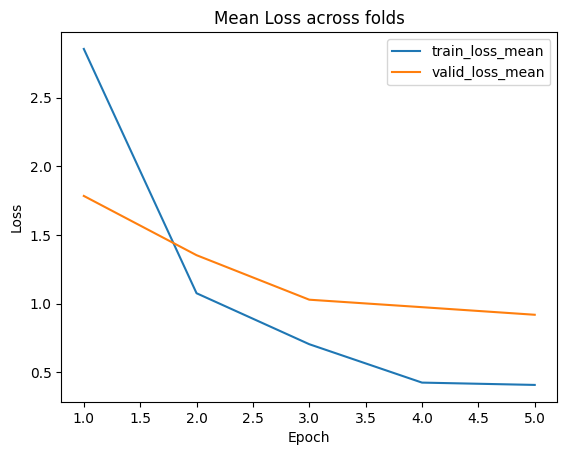

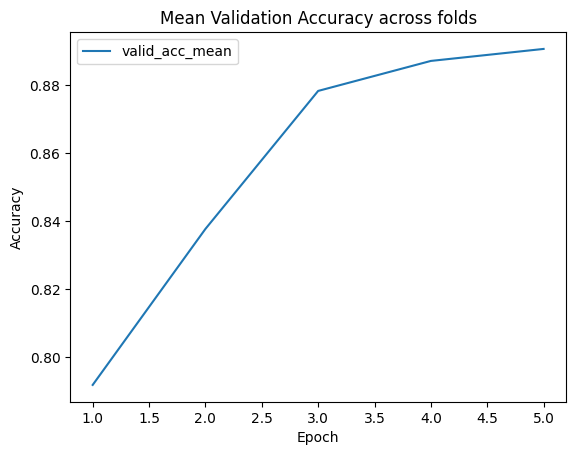

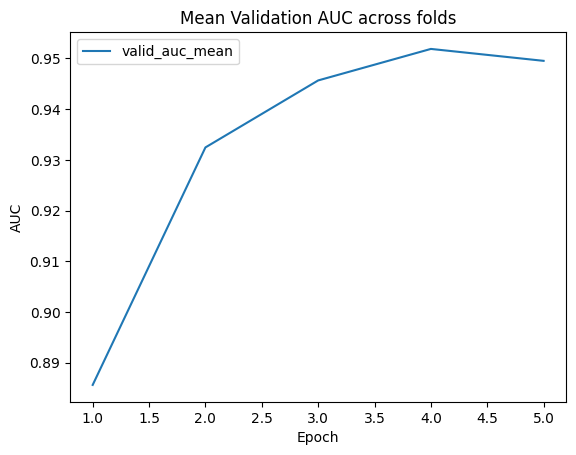

In [ ]:
avg = metrics.groupby("epoch")[["train_loss","valid_loss","valid_acc","valid_auc"]].mean().reset_index()

plt.figure()
plt.plot(avg["epoch"], avg["train_loss"], label="train_loss_mean")
plt.plot(avg["epoch"], avg["valid_loss"], label="valid_loss_mean")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Mean Loss across folds"); plt.legend(); plt.show()

plt.figure()
plt.plot(avg["epoch"], avg["valid_acc"], label="valid_acc_mean")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Mean Validation Accuracy across folds"); plt.legend(); plt.show()

plt.figure()
plt.plot(avg["epoch"], avg["valid_auc"], label="valid_auc_mean")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Mean Validation AUC across folds"); plt.legend(); plt.show()


In [ ]:
from IPython.display import display

best_by_fold = (
    metrics.sort_values(["fold", "valid_loss"])
           .groupby("fold", as_index=False)
           .first()
           .loc[:, ["fold","epoch","train_loss","valid_loss","valid_acc","valid_auc","lr"]]
)

display(
    best_by_fold.style.format({
        "train_loss":"{:.4f}",
        "valid_loss":"{:.4f}",
        "valid_acc":"{:.2%}",
        "valid_auc":"{:.4f}",
        "lr":"{:.2e}"
    })
)

summary = pd.DataFrame({
    "valid_loss_mean±std": [f"{best_by_fold['valid_loss'].mean():.4f} ± {best_by_fold['valid_loss'].std(ddof=1):.4f}"],
    "valid_acc_mean±std":  [f"{best_by_fold['valid_acc'].mean():.2%} ± {best_by_fold['valid_acc'].std(ddof=1):.2%}"],
    "valid_auc_mean±std":  [f"{best_by_fold['valid_auc'].mean():.4f} ± {best_by_fold['valid_auc'].std(ddof=1):.4f}"],
})
display(summary)


,fold,epoch,train_loss,valid_loss,valid_acc,valid_auc,lr
0,0,5,0.4038,0.9292,87.83%,0.9469,9.55e-06
1,1,3,0.5748,0.6797,93.12%,0.9697,6.55e-05
2,2,4,0.4725,0.9719,85.71%,0.9428,3.45e-05


,valid_loss_mean±std,valid_acc_mean±std,valid_auc_mean±std
0,0.8603 ± 0.1578,88.89% ± 3.82%,0.9531 ± 0.0145


In [ ]:
import os, shutil, time

SAVE_DIR = "/content/drive/MyDrive/real_vs_ai_saved"
os.makedirs(SAVE_DIR, exist_ok=True)


for p in model_paths:
    dst = os.path.join(SAVE_DIR, os.path.basename(p))
    shutil.copy2(p, dst)
    print("Saved:", dst)

# збережемо метрики, якщо є
if "metrics" in globals():
    metrics_path = os.path.join(SAVE_DIR, "metrics_history.csv")
    metrics.to_csv(metrics_path, index=False)
    print("Saved:", metrics_path)

for fn in ["loss_curve.png", "accuracy_curve.png", "auc_curve.png"]:
    src = f"/content/{fn}"
    if os.path.exists(src):
        dst = os.path.join(SAVE_DIR, fn)
        shutil.copy2(src, dst)
        print("Saved:", dst)

print("\nAll saved to:", SAVE_DIR)


Saved: /content/drive/MyDrive/real_vs_ai_saved/best_fold0_loss.pt
Saved: /content/drive/MyDrive/real_vs_ai_saved/best_fold1_loss.pt
Saved: /content/drive/MyDrive/real_vs_ai_saved/best_fold2_loss.pt
Saved: /content/drive/MyDrive/real_vs_ai_saved/metrics_history.csv

All saved to: /content/drive/MyDrive/real_vs_ai_saved


In [ ]:
!pip -q install gradio

import gradio as gr
import numpy as np, cv2, torch, timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224
MODEL_NAME = "tf_efficientnetv2_s"
CKPT_PATH = "/content/drive/MyDrive/kaggle_real_vs_ai/best_fold1_loss.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "| ckpt:", CKPT_PATH)

tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(),
    ToTensorV2(),
])

# load model
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=1).to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

@torch.no_grad()
def predict(img):
    if img is None:
        return "No image", 0.0, 0.0

    x = tfms(image=img)["image"].unsqueeze(0).to(device)
    logits = model(x)
    prob_real = torch.sigmoid(logits).item()   # P(Label==1) = P(Real)
    prob_ai = 1 - prob_real                    # P(Label==0) = P(AI)

    label = "Real photo" if prob_real >= 0.5 else "AI-generated"
    return label, float(prob_ai), float(prob_real)


demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Upload image"),
    outputs=[
        gr.Label(label="Predicted class"),
        gr.Number(label="P(AI)"),
        gr.Number(label="P(Real)"),
    ],
    title="Real vs AI Image Classifier (Demo)",
    description="Upload an image and the model will estimate whether it is AI-generated or a real photo."
)

demo.launch(share=True)


device: cpu | ckpt: /content/drive/MyDrive/kaggle_real_vs_ai/best_fold1_loss.pt
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://15bcba064bda3143c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# @torch.no_grad()
# def predict_test(model_paths):
#     dl_te = DataLoader(
#         ImgDataset(test_df, False, valid_tfms),
#         batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False
#     )

#     all_ids = None
#     all_preds = None
#     use_amp = (device.type == "cuda")

#     for mp in model_paths:
#         model = build_model().to(device)
#         model.load_state_dict(torch.load(mp, map_location=device))
#         model.eval()

#         preds = []
#         ids = []
#         for x, img_id in tqdm(dl_te, desc=f"infer {os.path.basename(mp)}"):
#             x = x.to(device)
#             with autocast(enabled=use_amp):
#               logits = model(x)
#             logits = logits.float().cpu().numpy().reshape(-1)
#             prob = 1 / (1 + np.exp(-logits))
#             preds.append(prob)
#             ids.extend(list(img_id))

#         preds = np.concatenate(preds)
#         if all_preds is None:
#             all_preds = preds
#             all_ids = ids
#         else:
#             all_preds += preds

#     all_preds /= len(model_paths)
#     return pd.DataFrame({id_col: all_ids, target_col: all_preds})

# pred_df = predict_test(model_paths)

# submission = sub_df[[id_col, target_col]].merge(pred_df, on=id_col, how="left", suffixes=("", "_pred"))
# submission[target_col] = submission[f"{target_col}_pred"].fillna(0.5)
# submission = submission[[id_col, target_col]]

# out_path = "/content/submission.csv"
# submission.to_csv(out_path, index=False)

# print("Saved:", out_path)
# submission.head()


infer best_fold0_loss.pt:   0%|          | 0/26 [00:00<?, ?it/s]

/tmp/ipython-input-4072009578.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


infer best_fold1_loss.pt:   0%|          | 0/26 [00:00<?, ?it/s]

/tmp/ipython-input-4072009578.py:24: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(-logits))


infer best_fold2_loss.pt:   0%|          | 0/26 [00:00<?, ?it/s]

Saved: /content/submission.csv


,Image,Label
0,946.jpg,1.865389e-06
1,947.jpg,1.000000e+00
2,948.jpg,1.898459e-02
3,949.jpg,9.993348e-01
4,950.jpg,1.915326e-13
